In [2]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import mayavi
import mayavi.mlab
import string
import subprocess
import functools
import cv2
import itertools

#on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
mayavi.mlab.options.offscreen = True



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [3]:
def import_shit():
    import local_models.local_models
    import local_models.algorithms
    import local_models.utils
    import local_models.linear_projections
    import local_models.loggin
    import local_models.TLS_models
    import numpy as np
    import logging
    import string
    import ml_battery.log


    logger = logging.getLogger(__name__)

    #reload(local_models.local_models)
    #reload(lm)
    #reload(local_models.loggin)
    #reload(local_models.TLS_models)
    np.warnings.filterwarnings('ignore')
    return logger
    
def mean_center(data, weights=None):
    return data - np.average(data, axis=0,weights=weights)

def load_converged_data(pth):
    convergededs = []
    for dat in sorted(os.listdir(pth)):
        convergededs.append(np.loadtxt(os.path.join(pth, dat)))
    return np.concatenate(convergededs, axis=0)

def plt_grid(fig, grid, data_avg, data_std):
    nodes = mayavi.mlab.points3d(grid[:,0], grid[:,1], grid[:,2], 
                                 scale_mode='scalar', scale_factor=1,
                                 colormap='gist_earth', figure=fig)
    nodes.glyph.scale_mode = 'scale_by_vector'
    nodes.mlab_source.dataset.point_data.vectors = np.ones((grid.shape[0],3))*(np.average(data_std)/60)
    nodes.mlab_source.dataset.point_data.scalars = (grid[:,1] - (data_avg[1]-3*data_std[1]))/(6*data_std[1])
    return nodes

def plt_data(fig, data, data_std):
    nodes = mayavi.mlab.points3d(data[:,0], data[:,1], data[:,2], 
                                 scale_mode='scalar', scale_factor=1,
                                 colormap='Greens', figure=fig)
    nodes.glyph.scale_mode = 'scale_by_vector'
    nodes.mlab_source.dataset.point_data.vectors = np.ones((data.shape[0],3))*(np.average(data_std)/60)
    nodes.mlab_source.dataset.point_data.scalars = np.ones((data.shape[0]))
    return nodes

def get_normals(kernel, linear_models, data):
    if hasattr(kernel.bandwidth, "__call__"):
        linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, k=kernel.k)
    else:
        linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, r=kernel.support_radius())
    return linear_params_vecs

def align_normals(data, normals, k=10, iterations=100):
    balltree = sklearn.neighbors.BallTree(data)
    pairwise_nearest_indices = balltree.query(data,k=k,sort_results=True,return_distance=False)
    for iteration in range(iterations):
        alignments = []
        for index in range(1,pairwise_nearest_indices.shape[1]):
            alignment = np.einsum("ij,ij->i",normals,normals[pairwise_nearest_indices[:,index]])
            alignments.append(alignment)
        alignment = np.average(alignments, axis=0)
        wrong_alignment = np.sign(alignment)
        normals = normals*wrong_alignment.reshape(-1,1)
    return normals

def align_edge_normals(data, normals, edge_range=0.1):
    data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
    graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, -edge_range)
    mins = data < graph_bounds[:1]
    maxes = data > graph_bounds[1:]
    mins_alignment = np.sign(np.einsum("ij,ij->i",mins,-1*normals))
    maxes_alignment = np.sign(np.einsum("ij,ij->i",maxes,normals))
    mins_alignment += np.logical_not(mins_alignment) # turn 0s into 1s (so they don't change)
    maxes_alignment += np.logical_not(maxes_alignment)    
    return normals*mins_alignment.reshape(-1,1)*maxes_alignment.reshape(-1,1)

def plt_normals(fig, normals, data, data_std):
    nodes = mayavi.mlab.quiver3d(data[:,0], data[:,1], data[:,2],
                                 normals[:,0], normals[:,1], normals[:,2],
                                 scale_mode='scalar', scale_factor=np.average(data_std)/5,
                                 colormap='Purples', figure=fig, line_width=1.0)
    return nodes

def normalize_view(fig, data_avg, data_std, azimuth=0, elevation=0):
    mayavi.mlab.view(azimuth=azimuth, elevation=elevation, distance=15*np.average(data_std), focalpoint=(data_avg[0], data_avg[1], data_avg[2]))
    
def plt_and_save(data, grid, normals, pth):
    data_avg = np.average(data, axis=0)
    data_std = np.std(data, axis=0)
    figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 500))
    data_nodes = plt_data(figure, data, data_std)
    converged_nodes = plt_grid(figure, grid, data_avg, data_std)
    normal_vecs = plt_normals(figure, normals, grid, data_std)
    neg_normal_vecs = plt_normals(figure, -normals, grid, data_std)
    normalize_view(figure, data_avg, data_std)
    mayavi.mlab.savefig(pth, magnification=2)
    mayavi.mlab.close(figure)

def serialize_plt(pth):
    import zlib
    with open(pth, 'rb') as f:
        dat = f.read()
    return zlib.compress(dat)
   
def deserialize_plt(dat, pth):
    import zlib
    with open(pth, 'wb') as f:
        f.write(zlib.decompress(dat))
    return pth

def distributed_plt_and_save(data, grid, bandwidth):
    import numpy as np
    import mayavi
    import mayavi.mlab
    import string
    import os
    #on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
    mayavi.mlab.options.offscreen = True
    
    unique_id = "".join(np.random.choice(list(string.ascii_lowercase), replace=True, size=20))
    pth = "/ramfs/{}.png".format(unique_id)
    try:
        plt_and_save(data, grid, bandwidth, pth)
        result = serialize_plt(pth)
    except:
        os.remove(pth)

In [4]:
FRESH=True

In [5]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [6]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [7]:
data_file = "/home/brown/Downloads/subject001/3d/andreadm2.stl"

In [8]:
import stl

tri_mesh = stl.mesh.Mesh.from_file(data_file).points.reshape(-1,3)

In [9]:
tri_mesh.shape

(346758, 3)

In [10]:
data, cts = np.unique(tri_mesh, axis=0, return_counts=True)

In [11]:
data.shape

(58659, 3)

In [12]:
(data.shape[0]*100)**(1/3)

180.348091843

In [13]:
np.mean(data, axis=0)

array([ -71.71989 , -340.46124 ,   31.036196], dtype=float32)

In [14]:
KERNEL=local_models.local_models.TriCubeKernel
RUN = 2

project_dir = "../data/quadrics_{}_{:03d}".format(kernel_names[KERNEL], RUN)

os.makedirs(project_dir, exist_ok=1)

In [15]:
A = np.array([[0,0,0,1]]).T
ORIGIN = np.array([[0,0,0]])
ONE = np.array([[1]])

import quadrics_utils

def diagonalize_quadric_and_translate(Q,X):
    Q_s = Q[:-1,:-1]
    _, U = np.linalg.eig(Q_s)
    UTQs = U.T@Q_s
    UL = np.diag(UTQs@U)
    UR = UTQs@X.T + U.T@Q[:-1,-1:]
    BR = np.einsum('kj,kj->k', X@Q_s, X).reshape(-1,1) + 2*X@Q[:-1,-1:] + Q[-1,-1]
    return (U, UL, UR, BR)

def array_roots(coeffses):
    ret = np.zeros((coeffses.shape[0], coeffses.shape[1]-1), dtype=complex)
    for i, coeffs in enumerate(coeffses):
        nproots = np.roots(coeffs.flatten())
        ret[i] = nproots
    return ret

quadric_projection_polynomial_coefficients = [
    quadrics_utils.k6,
    quadrics_utils.k5,
    quadrics_utils.k4,
    quadrics_utils.k3,
    quadrics_utils.k2,
    quadrics_utils.k1,
    quadrics_utils.k0,
]
def orthogonal_quadric_projection(X,Q,projection_funcs):
    U, ul, ur, br = diagonalize_quadric_and_translate(Q,X)
    a,b,c = ul.reshape(-1,1,1)
    e,f,g = ur
    d = br
    e,f,g,d = list(map(lambda x: x.reshape(-1, 1), [e,f,g,d]))

    coeffses = list(map(lambda func: func(a,b,c,d,e,f,g), quadric_projection_polynomial_coefficients))
    # the first coefficient doesn't depend on x, so it needs tiling.
    coeffses[0] = np.repeat(coeffses[0], X.shape[0], axis=0)
    coeffses = np.stack(coeffses, axis=1)
    x = np.ma.array(array_roots(coeffses))
    candidates = x.imag == 0
    x.mask = ~candidates
    y = quadrics_utils.y_as_x(a,b,c,d,e,f,g,x)
    z = quadrics_utils.z_as_x(a,b,c,d,e,f,g,x)
    pts = np.ma.stack((x,y,z), axis=1)
    dists = np.sum(pts**2, axis=1)
    mindists = np.argmin(dists, axis=1)
    X_indices = np.arange(X.shape[0])
    best_pts = np.array(pts[X_indices,:,mindists], dtype=float)
    best_dists = np.array(dists[X_indices,mindists],dtype=float)
    return unrotate_and_translate(U, X, best_pts), best_dists

k_jac_funcs=None
projection_funcs = {
    "k_mat": quadrics_utils.k_mat,
    "other_dims_as_x": lambda a,b,c,d,e,f,g,x: [quadrics_utils.y_as_x(a,b,c,d,e,f,g,x), quadrics_utils.z_as_x(a,b,c,d,e,f,g,x)],
    "k_jac": k_jac_funcs,
}
def orthogonal_quadric_projection(X,Q,projection_funcs):
    U, ul, ur, br = diagonalize_quadric_and_translate(Q,X)
    #put all of the dimensions right for math stuff
    args = (
        list(ul.reshape(-1,1,1)) +
        [br.reshape(-1,1)] +
        list(ur.reshape(ur.shape[0], -1, 1))
    )

    coeffses = projection_funcs["k_mat"](*args)
    # depending on which variables are in an equation, it may need to be tiled
    for i, coeff in enumerate(coeffses):
        if coeff.shape[0] != X.shape[0]:
            coeffses[i] = np.repeat(coeff, X.shape[0], axis=0)

    coeffses = np.stack(coeffses, axis=1)
    x = np.ma.array(array_roots(coeffses))
    candidates = x.imag == 0
    x.mask = ~candidates
    other_dims = projection_funcs["other_dims_as_x"](*(args + [x]))

    pts = np.ma.stack([x] + other_dims, axis=1)
    dists = np.sum(pts**2, axis=1)
    mindists = np.argmin(dists, axis=1)
    X_indices = np.arange(X.shape[0])
    best_pts = np.array(pts[X_indices,:,mindists], dtype=float)
    best_dists = np.array(dists[X_indices,mindists],dtype=float)
    return unrotate_and_translate(U, X, best_pts), best_dists

def orthogonal_quadric_projection_with_jacobian(X,Q,projection_funcs):
    U, ul, ur, br = diagonalize_quadric_and_translate(Q,X)
    #put all of the dimensions right for math stuff
    args = (
        list(ul.reshape(-1,1,1)) +
        [br.reshape(-1,1)] +
        list(ur.reshape(ur.shape[0], -1, 1))
    )

    coeffses = projection_funcs["k_mat"](*args)
    # depending on which variables are in an equation, it may need to be tiled
    for i, coeff in enumerate(coeffses):
        if coeff.shape[0] != X.shape[0]:
            coeffses[i] = np.repeat(coeff, X.shape[0], axis=0)

    coeffses = np.stack(coeffses, axis=1)
    x = np.ma.array(array_roots(coeffses))
    candidates = x.imag == 0
    x.mask = ~candidates
    other_dims = projection_funcs["other_dims_as_x"](*(args + [x]))

    pts = np.ma.stack([x] + other_dims, axis=1)
    dists = np.sum(pts**2, axis=1)
    mindists = np.argmin(dists, axis=1)
    X_indices = np.arange(X.shape[0])
    best_pts = np.array(pts[X_indices,:,mindists], dtype=float)
    best_dists = np.array(dists[X_indices,mindists],dtype=float)
    
    k_jac = projection_funcs["k_jac"]
    jac1 = [f(*args) for f in k_jac[0]]
    jacn = [[k_jac[j][i](*(args + [best_pts[:,:1], jac1[i]])) for i in range(len(k_jac[0]))] for j in range(1,len(k_jac))]
    jac = [jac1] + jacn
    # depending on which variables are in an equation, it may need to be tiled
    for i, var in enumerate(jac):
        for j, der in enumerate(var):
            if der.shape[0] != X.shape[0]:
                jac[i][j] = np.repeat(der, X.shape[0], axis=0)
            jac[i][j] = jac[i][j].reshape(-1,1,1)
    print(list(map(lambda y: list(map(lambda x: x.shape, y)), jac)))

    jac = np.block(jac)
    print(jac.shape)
    
    return unrotate_and_translate(U, X, best_pts), unrotate_jac(U, X, jac), best_dists
    

def unrotate_and_translate(U, orig_X, new_X):
    return new_X@U.T + orig_X
    #return np.einsum('ji,ki->kj',U,orig_X) + new_X
def unrotate_jac(U, orig_X, jac):
    return U@jac

In [16]:
def test_diagonalize_quadratic_and_translate():
    q = np.array([ # an ellipse
        [0.5,0,0,0],
        [0,0.4,0,0],
        [0,0,0.3,0],
        [0,0,0,-1],
    ])
    x = np.random.uniform(size=3).reshape(1,-1)
    x = np.ones(3).reshape(1,-1)*0.01
    x[0,2] = 1
    
    _, ul, ur, br = diagonalize_quadric_and_translate(q,x)
    
    q1 = np.block([[np.diag(ul), ur],[ur.T, br]])
    
    _,U = np.linalg.eig(q[:3,:3])
    E = np.block([[U, x.T],[ORIGIN, 1]])
    q2 = E.T@q@E
    
    assert np.allclose(q1,q2)
test_diagonalize_quadratic_and_translate()

In [17]:
#q = np.random.uniform(size=(4,4))
#q += q.T
q = np.array([ # an ellipse
    [0.5,0,0,0],
    [0,0.25,0,0],
    [0,0,0.125,0],
    [0,0,0,-1],
])
q = np.array([ # an elliptic paraboloid
    [0.5,0,0,0],
    [0,0.25,0,0],
    [0,0,0,-1],
    [0,0,-1,0.1],
])
init_q = q
u = np.random.uniform(size=(3,3))
u += u.T
_, u = np.linalg.eig(u)
print(u)
print(np.linalg.norm(u, axis=0))
E = np.block([[u, np.zeros((3,1))],[np.zeros(3), 1]])
q = E.T@q@E
print(q)
x = np.random.uniform(size=3).reshape(1,-1)
x = np.ones(3).reshape(1,-1)*0.01
x[0,2] = 1

q

[[-0.67376632 -0.63784999 -0.37307686]
 [-0.55176238  0.77009738 -0.32016917]
 [-0.49152542  0.00986943  0.8708073 ]]
[1. 1. 1.]
[[ 0.30309095  0.10865323  0.16984763  0.49152542]
 [ 0.10865323  0.3516888   0.05734317 -0.00986943]
 [ 0.16984763  0.05734317  0.09522024 -0.8708073 ]
 [ 0.49152542 -0.00986943 -0.8708073   0.1       ]]


array([[ 0.30309095,  0.10865323,  0.16984763,  0.49152542],
       [ 0.10865323,  0.3516888 ,  0.05734317, -0.00986943],
       [ 0.16984763,  0.05734317,  0.09522024, -0.8708073 ],
       [ 0.49152542, -0.00986943, -0.8708073 ,  0.1       ]])

In [18]:
q[:3,3:]

array([[ 0.49152542],
       [-0.00986943],
       [-0.8708073 ]])

In [19]:
_, ul, ur, br = diagonalize_quadric_and_translate(q,x)

In [20]:
br

array([[-1.53213022]])

In [21]:
x

array([[0.01, 0.01, 1.  ]])

In [22]:
Q1 = np.block([[np.diag(ul), ur],[ur.T, br]])
Q1

array([[-1.62100910e-17,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  5.00000000e-01,  0.00000000e+00,
        -1.93096509e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.50000000e-01,
         7.94964558e-02],
       [ 1.00000000e+00, -1.93096509e-01,  7.94964558e-02,
        -1.53213022e+00]])

In [23]:
_,U = np.linalg.eig(q[:3,:3])

In [24]:
E = np.block([[U, x.T],[ORIGIN, 1]])
E

array([[ 0.49152542, -0.67376632,  0.55176238,  0.01      ],
       [-0.00986943, -0.63784999, -0.77009738,  0.01      ],
       [-0.8708073 , -0.37307686,  0.32016917,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [25]:
q

array([[ 0.30309095,  0.10865323,  0.16984763,  0.49152542],
       [ 0.10865323,  0.3516888 ,  0.05734317, -0.00986943],
       [ 0.16984763,  0.05734317,  0.09522024, -0.8708073 ],
       [ 0.49152542, -0.00986943, -0.8708073 ,  0.1       ]])

In [26]:
np.round(E.T@q@E,3)

array([[-0.   ,  0.   , -0.   ,  1.   ],
       [ 0.   ,  0.5  , -0.   , -0.193],
       [ 0.   , -0.   ,  0.25 ,  0.079],
       [ 1.   , -0.193,  0.079, -1.532]])

In [27]:
E

array([[ 0.49152542, -0.67376632,  0.55176238,  0.01      ],
       [-0.00986943, -0.63784999, -0.77009738,  0.01      ],
       [-0.8708073 , -0.37307686,  0.32016917,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [28]:
pts, dists = orthogonal_quadric_projection(x,q, projection_funcs)
pts2, dists2 = orthogonal_quadric_projection(x,q, projection_funcs)
print(pts2, dists2)

[[0.5383172  0.08533322 0.48432215]] [0.55071781]


In [29]:
orthogonal_quadric_projection(x,q,projection_funcs)

(array([[0.5383172 , 0.08533322, 0.48432215]]), array([0.55071781]))

In [30]:
pts, dists

(array([[0.5383172 , 0.08533322, 0.48432215]]), array([0.55071781]))

In [31]:
pts2, dists2

(array([[0.5383172 , 0.08533322, 0.48432215]]), array([0.55071781]))

In [32]:
dists

array([0.55071781])

In [33]:
pts.shape

(1, 3)

In [34]:
pt1 = np.ones((1,4))
pt1[:,:3] = pts
pt1

array([[0.5383172 , 0.08533322, 0.48432215, 1.        ]])

In [35]:
pt1@q@pt1.T

array([[2.12288146e-05]])

In [36]:
x.shape, q.shape

((1, 3), (4, 4))

In [37]:
x = (np.random.uniform(size=(3000,3))-0.5)*10

In [38]:
pts, dists = orthogonal_quadric_projection(x,q, projection_funcs)

In [39]:
#pts, dists = orthogonal_quadric_projection2(x,q, projection_funcs)

In [40]:
check_pts, check_dists = orthogonal_quadric_projection(np.array(pts),q, projection_funcs)

In [41]:
check_dists

array([1.06442486e-11, 7.34895229e-13, 8.34915586e-13, ...,
       1.90087620e-13, 4.16364624e-15, 7.83137416e-11])

In [42]:
pts, dists = orthogonal_quadric_projection(x,q, projection_funcs)

In [43]:
print(pts.shape, dists.shape)

(3000, 3) (3000,)


In [44]:
def imshow(pth, cv2color=cv2.IMREAD_COLOR, **kwargs):
    img = cv2.imread(pth, cv2color)
    img = trim_whiteborder(img)
    plt.imshow(img, **kwargs)
    plt.axis("off")

In [45]:
pth = os.path.join(project_dir, "quadric_test.png")

data_avg = np.average(pts, axis=0)
data_std = np.std(pts, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 1000))
#data_nodes = plt_data(figure, x[np.random.choice(np.arange(x.shape[0]), size=40, replace=False)], data_std)
vecs = pts-x
#mayavi.mlab.quiver3d(x[:,0], x[:,1], x[:,2], vecs[:,0], vecs[:,1], vecs[:,2])
quadric_nodes = plt_grid(figure, pts, data_avg, data_std)
#ellipse_axes = plt_data(figure, np.diag(np.sqrt(1/np.diag(init_q[:3,:3])))@u, data_std*10)

normalize_view(figure, data_avg, data_std)
mayavi.mlab.savefig(pth, magnification=2)
mayavi.mlab.close(figure)

In [46]:
def trim_whiteborder(img, ratio=1.1):
    img = cv2.bitwise_not(img)
    print(img.shape)
    im_sq = img**2
    sum_sq_cols = np.sum(im_sq, axis=0)
    sum_sq_rows = np.sum(im_sq, axis=1)
    if len(img.shape) > 2:
        sum_sq_cols = np.sum(sum_sq_cols, axis=1)
        sum_sq_rows = np.sum(sum_sq_rows, axis=1)
    print(sum_sq_cols.shape, sum_sq_rows.shape)
    first_nonzero_col = (sum_sq_cols!=0).argmax()
    last_nonzero_col = sum_sq_cols.shape[0] - (sum_sq_cols[::-1]!=0).argmax()
    first_nonzero_row = (sum_sq_rows!=0).argmax()
    last_nonzero_row = sum_sq_rows.shape[0] - (sum_sq_rows[::-1]!=0).argmax()
    print(first_nonzero_col, last_nonzero_col, first_nonzero_row, last_nonzero_row)
    totally_trimmed = img[first_nonzero_row:last_nonzero_row, first_nonzero_col:last_nonzero_col]
    if len(img.shape) == 2:
        just_a_little_whitespace = np.zeros((
            int(totally_trimmed.shape[0]*ratio), 
            int(totally_trimmed.shape[1]*ratio)
        ), dtype=np.uint8)
    else:
        just_a_little_whitespace = np.zeros((
            int(totally_trimmed.shape[0]*ratio), 
            int(totally_trimmed.shape[1]*ratio),
            img.shape[2]
        ), dtype=np.uint8)
    jalw_middle_section_start = ((np.array(just_a_little_whitespace.shape) - np.array(totally_trimmed.shape))/2).astype(int)
    just_a_little_whitespace[
        jalw_middle_section_start[0]:jalw_middle_section_start[0] + totally_trimmed.shape[0],
        jalw_middle_section_start[1]:jalw_middle_section_start[1] + totally_trimmed.shape[1]
    ] = totally_trimmed
    #return just_a_little_whitespace
    return cv2.bitwise_not(just_a_little_whitespace)
        

(2000, 2000, 3)
(2000,) (2000,)
183 1465 123 1840


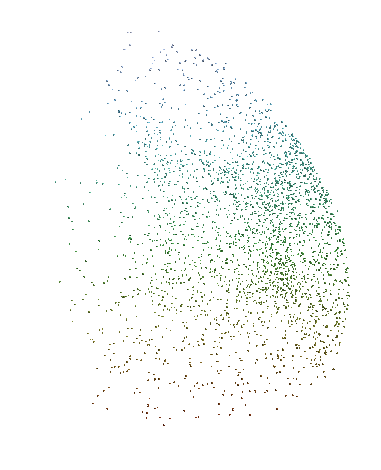

In [47]:
blah = imshow(pth)

In [48]:
def weighted_avg_and_std(values, weights=None, axis=None):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    if weights is None:
        return np.average(values, axis=axis), np.std(values, axis=axis)
    average = np.average(values, weights=weights, axis=axis)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=axis)
    return (average, np.sqrt(variance))

In [49]:
import scipy.optimize
import sklearn.utils
import sklearn.base

class QuadricModel(sklearn.base.RegressorMixin):
    def __init__(self):
        pass
    def get_params(self, *args, **kwargs):
        return dict()
    def set_params(self, params, *args, **kwargs):
        pass

    
    def _optimizer_logger(self, xk, *args):
        logging.info("quadric modeling: it{}, xk{}".format(self.i, xk))
        self.i += 1      
            
    def fit(self, X, y=None, sample_weight=None, beta0=None):
        logging.info("fitting quadric model")
        X = sklearn.utils.check_array(X)
        if beta0 is None:
            #this allows us to orient the data to set an initial set of parameters
            global_linear_model = local_models.TLS_models.LinearODR_mD(2)
            global_linear_model.fit(X, sample_weight=sample_weight)
            global_linear_vecs = global_linear_model.cov_eigenvectors[global_linear_model.cov_eigenvalues_sorter]
            global_linear_mean = global_linear_model.intercept_

            transformed_X = (X-global_linear_mean)@global_linear_vecs.T

            transformed_q = np.zeros((4,4))
            
            # an elliptic paraboloid pointing in the smallest eigenvector direction
            '''
            transformed_q[0,0] = 1/weighted_avg_and_std(transformed_X[0], weights=None)[1]**2 #flat-ish in x
            transformed_q[1,1] = 1/weighted_avg_and_std(transformed_X[1], weights=None)[1]**2 #flat-ish in y
            transformed_q[2,3] = transformed_q[3,2] = -1 # elliptic paraboloid pointing in z direction
            '''
            
            # an ellipse with axes in the various directions
            transformed_q[np.diag_indices(3)] = 1/global_linear_model.cov_eigenvalues[global_linear_model.cov_eigenvalues_sorter]**2
            transformed_q[3,3] = -1
            #print(np.diag(transformed_q), weighted_avg_and_std(transformed_X, weights = sample_weight, axis=0)[1])
            
            #print(transformed_q)
            #print(global_linear_mean)
            E = np.block([[global_linear_vecs, global_linear_mean.reshape(-1,1)],[np.zeros(3),1]])
            Einv = np.linalg.inv(E)
            q = Einv.T@transformed_q@Einv
            print(q)
            beta0 = q[np.triu_indices(4)]
        
        beta0 /= beta0[-1]
        
        self.i = 0
        self.solution = scipy.optimize.minimize(self._loss, beta0[:-1], args=(X, sample_weight), callback=self._optimizer_logger)#, method = 'Nelder-Mead')
        self.coef_ = self.solution.x
        self.intercept_ = np.array([])
        return self
            
    def _loss(self, beta, X, sample_weight=None):
        q = np.zeros((4,4))
        beta = np.concatenate((beta, [1]))
        q[np.triu_indices(4)] = beta
        q[3,3] = 1
        q += q.T
        q[np.diag_indices(4)] /= 2
        pts, dists = orthogonal_quadric_projection(X,q,projection_funcs)

        #pts, jac, dists = orthogonal_quadric_projection_with_jacobian(X,q,projection_funcs)
        
        if sample_weight is not None:
            dists *= sample_weight
        lost = np.sum(dists)
        #total_jac = np.einsum('ki,kij->ij', (X - pts), jac)
        #if lost > 20:
        #    print(q)
        #print(lost)
        return lost#, total_jac

In [50]:
qm = QuadricModel()
qm.fit(pts)#, beta0=q[np.triu_indices(4)]+0.001)

[[ 0.07879929 -0.0141152   0.06286708 -0.02376961]
 [-0.0141152   0.0970706  -0.12928873  0.1653156 ]
 [ 0.06286708 -0.12928873  0.33178246 -0.41396382]
 [-0.02376961  0.1653156  -0.41396382 -0.43836932]]


In [51]:
qm.solution

      fun: 1.1545693882294028
 hess_inv: array([[ 4.62506021e+10,  1.69757951e+10,  2.80197580e+10,
         7.26582169e+10,  5.49833782e+10,  8.58133664e+09,
        -8.38285745e+08,  1.08599943e+10, -1.26296365e+11],
       [ 1.69757952e+10,  6.23078635e+09,  1.02843563e+10,
         2.66684313e+10,  2.01810684e+10,  3.14968901e+09,
        -3.07683931e+08,  3.98604623e+09, -4.63557473e+10],
       [ 2.80197581e+10,  1.02843563e+10,  1.69750621e+10,
         4.40181440e+10,  3.33102898e+10,  5.19878588e+09,
        -5.07854228e+08,  6.57925300e+09, -7.65134602e+10],
       [ 7.26582169e+10,  2.66684313e+10,  4.40181439e+10,
         1.14143735e+11,  8.63771289e+10,  1.34810055e+10,
        -1.31692010e+09,  1.70607037e+10, -1.98407551e+11],
       [ 5.49833783e+10,  2.01810684e+10,  3.33102897e+10,
         8.63771290e+10,  6.53650275e+10,  1.02016159e+10,
        -9.96566101e+08,  1.29105167e+10, -1.50142928e+11],
       [ 8.58133667e+09,  3.14968901e+09,  5.19878588e+09,
         1

In [52]:
qq = np.zeros((4,4))
qq[np.triu_indices(4)] = np.concatenate((qm.coef_, [1]))
qq += qq.T
qq[np.diag_indices(4)] /= 2
np.round(qq,3)

array([[-2.0846496e+04, -7.6514860e+03, -1.2629464e+04, -3.2749021e+04],
       [-7.6514860e+03, -2.4782710e+04, -3.8678200e+03,  3.7777200e+02],
       [-1.2629464e+04, -3.8678200e+03, -4.8945980e+03,  5.6924894e+04],
       [-3.2749021e+04,  3.7777200e+02,  5.6924894e+04,  1.0000000e+00]])

In [53]:
q

array([[ 0.30309095,  0.10865323,  0.16984763,  0.49152542],
       [ 0.10865323,  0.3516888 ,  0.05734317, -0.00986943],
       [ 0.16984763,  0.05734317,  0.09522024, -0.8708073 ],
       [ 0.49152542, -0.00986943, -0.8708073 ,  0.1       ]])

In [54]:
q

array([[ 0.30309095,  0.10865323,  0.16984763,  0.49152542],
       [ 0.10865323,  0.3516888 ,  0.05734317, -0.00986943],
       [ 0.16984763,  0.05734317,  0.09522024, -0.8708073 ],
       [ 0.49152542, -0.00986943, -0.8708073 ,  0.1       ]])

In [55]:
qq.shape

(4, 4)

In [56]:
q.shape

(4, 4)

In [57]:
np.array(pts)

array([[ 0.22154492,  1.14058941,  0.55479045],
       [ 1.81872468, -1.95776169,  3.42825888],
       [-1.14905968,  1.37888974, -0.16698182],
       ...,
       [ 0.22358705,  2.47940081,  2.1900757 ],
       [-0.01934217,  1.48104939,  0.53494599],
       [ 1.31972056, -3.63798663,  4.31532586]])

In [58]:
qfit_pth = os.path.join(project_dir, "qfit_test.png")
qfit_pts, qfit_dists = orthogonal_quadric_projection(x,qq,projection_funcs)

data_avg = np.average(qfit_pts, axis=0)
data_std = np.std(qfit_pts, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 1000))
#data_nodes = plt_data(figure, x[np.random.choice(np.arange(x.shape[0]), size=40, replace=False)], data_std)
vecs = qfit_pts-pts
#mayavi.mlab.quiver3d(x[:,0], x[:,1], x[:,2], vecs[:,0], vecs[:,1], vecs[:,2])
quadric_nodes = plt_grid(figure, qfit_pts, data_avg, data_std)
#other_nodes = plt_grid(figure, pts, data_avg, data_std)

normalize_view(figure, data_avg, data_std)
mayavi.mlab.savefig(qfit_pth, magnification=2)
mayavi.mlab.close(figure)


(2000, 2000, 3)
(2000,) (2000,)
193 1467 118 1843


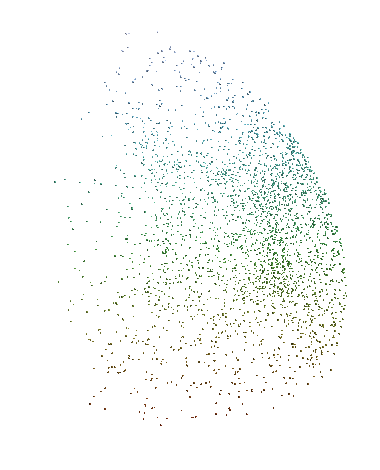

In [59]:
imshow(qfit_pth)

In [60]:
np.sum(np.isnan(pts))

0

In [61]:
local_quadrics = local_models.local_models.LocalModels(QuadricModel())
local_quadrics.fit(pts)

In [62]:
avg_pt_dist = np.average(local_quadrics.index.query(pts, k=2)[0][:,1])

In [63]:
bandwidth = avg_pt_dist*64
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)

In [ ]:
try:
    stuff = local_quadrics.transform(pts,
        r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel,
        neighbor_beta0s=False, batch_size=int(pts.shape[0]/32), return_models=True)
except:
    logging.exception("transformation failed!")

[[ 0.26997088 -0.38665474  0.5005991  -0.16377088]
 [-0.38665474  1.93159097 -2.12019813  0.79724746]
 [ 0.5005991  -2.12019813  2.67843921 -1.17477756]
 [-0.16377088  0.79724746 -1.17477756 -0.39421309]]
[[ 1.07451019  2.38203903  1.24487566 -0.66271889]
 [ 2.38203903  6.5939681   3.37593958 -1.21775479]
 [ 1.24487566  3.37593958  1.91016238 -1.02963945]
 [-0.66271889 -1.21775479 -1.02963945  0.26377632]]
[[ 0.21217955  0.09993774 -0.37021808  0.35085391]
 [ 0.09993774  0.97119292 -1.88965635  0.54897052]
 [-0.37021808 -1.88965635  4.64415134 -1.82346066]
 [ 0.35085391  0.54897052 -1.82346066  0.04529998]]
[[  0.67395752   2.21722747  -2.58863936   8.6407621 ]
 [  2.21722747   8.61702807  -9.97707063  33.00890039]
 [ -2.58863936  -9.97707063  11.86160186 -38.65196332]
 [  8.6407621   33.00890039 -38.65196332 126.18652856]]
[[ 0.53489242 -0.466911    1.01611211 -0.61885201]
 [-0.466911    0.98194055 -1.60284133  1.10854616]
 [ 1.01611211 -1.60284133  3.31034738 -2.28312543]
 [-0.618852

In [1900]:
q

array([[ 0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0.4,  0. ,  0. ],
       [ 0. ,  0. ,  0.3,  0. ],
       [ 0. ,  0. ,  0. , -1. ]])

In [424]:
import importlib; importlib.reload(quadrics_utils)

<module 'quadrics_utils' from '/home/brown/python_packages/local_models/examples/quadrics_utils.py'>

In [1860]:
def collect_best(expr, measure=sympy.count_ops):
    best = expr
    best_score = measure(expr)
    perms = itertools.permutations(expr.free_symbols)
    permlen = np.math.factorial(len(expr.free_symbols))
    print(permlen)
    for i, perm in enumerate(perms):
        if (permlen > 1000) and not (i%int(permlen/100)):
            print(i)
        collected = sympy.collect(expr, perm)
        if measure(collected) < best_score:
            best_score = measure(collected)
            best = collected
        else:
            factored = sympy.factor(expr)
            if measure(factored) < best_score:
                best_score = measure(factored)
                best = factored
    return best
    
def product(args):
    arg = next(args)
    try:
        return arg*product(args)
    except:
        return arg
    
def rcollect_best(expr, measure=sympy.count_ops):
    best = collect_best(expr, measure)
    best_score = measure(best)
    if expr == best:
        return best
    if isinstance(best, sympy.Mul):
        return product(map(rcollect_best, best.args))
    if isinstance(best, sympy.Add):
        return sum(map(rcollect_best, best.args))

In [3579]:
def derive_quadratic_orthogonal_projection_1D_polynomial(n):
    import sympy
    
    Q_sym = sympy.symarray("q", (n+1, n+1))
    Q = sympy.Matrix(np.zeros((n+1,n+1), dtype=int))
    for i, j in itertools.product(range(n+1), range(n+1)):
        if i == n or j == n or i == j:
            Q[i,j] = Q_sym[max(i,j),min(i,j)]
    print(Q)

    x_sym = sympy.symarray("x", n+1)
    X = sympy.Matrix(np.ones((n+1, 1), dtype=int))
    for i in range(n):
        X[i] = x_sym[i]
        
    P = sympy.Matrix(np.zeros((n-1, n+1), dtype=int))
    for i in range(n-1):
        P[i,0] = X[i+1]
        P[i,i+1] = -X[0]
    
    QXP = P*Q*X
    
    other_dims_as_x0 = [sympy.solve(QXP[i], X[i+1])[0] for i in range(n-1)] 
    
    XQX = sympy.expand((X.T*Q*X)[0])
    XQX_as_x0 = XQX.subs({X[i+1]:other_dims_as_x0[i] for i in range(n-1)})
    for sub in other_dims_as_x0:
        XQX_as_x0 *= sympy.fraction(sub)[1]**2
    XQX_as_x0 = sympy.cancel(XQX_as_x0)
    XQX_as_x0 = sympy.simplify(XQX_as_x0)
    XQX_as_x0 = sympy.poly(XQX_as_x0, X[0])
    
    return (X, Q, XQX_as_x0, other_dims_as_x0)
    

In [ ]:
def collectify_polynomial_coefficients(poly):
    return [rcollect_best(formula) for formula in poly.all_coeffs()]

In [3011]:
sorted(map(lambda x: x**2, range(4)))

[0, 1, 4, 9]

In [ ]:
import shelve

def funcify(signature, returnable):
    return "def {}: return {}\n".format(signature, returnable)

def get_signature(expr, name):
    return name+str(tuple(sorted(map(str, expr.free_symbols))))

k_mat = sympy.Matrix(collected)
k_jac = k_mat.jacobian([a,b,c,d,e,f,g])

with open("quadrics_formulae.shelf", "w") as quadrics_formulae:
    quadrics_formulae[3] = {
        "k_mat":  sympy.Matrix(collected),
        "k_jac": None,
        "other_dims_as_x": other_dims_as_x0,
}

In [3603]:
X,Q,poly,other_dims_as_x = derive_quadratic_orthogonal_projection_1D_polynomial(3)

Matrix([[q_0_0, 0, 0, q_3_0], [0, q_1_1, 0, q_3_1], [0, 0, q_2_2, q_3_2], [q_3_0, q_3_1, q_3_2, q_3_3]])


In [3589]:
func_x0 = sympy.Function('fx_0')(*sorted(Q.free_symbols, key=str))
func_xn = [sympy.Function('fx_{}'.format(i))(*(sorted(Q.free_symbols, key=str) + [func_x0]))]

In [3600]:
dx_dvars = []
for var in sorted(Q.free_symbols, key=str):
    dx_dvars.append(
        sympy.solve(sympy.diff(poly.as_expr().subs(X[0], func_x0), var), sympy.diff(func_x0, var))[0]
    )
dotherdims_dvars = []
for i, otherdim in enumerate(X[1:-1]):
    dotherdims_dvars.append([])
    for j, var in enumerate(sorted(Q.free_symbols, key=str)):
        dotherdims_dvars[-1].append(
            sympy.diff(other_dims_as_x[i].subs(X[0], func_x0), var)
        )

In [3604]:
k_jac = [dx_dvars] + dotherdims_dvars

In [3663]:
jaco_vars = [sympy.Symbol("dx_0_" + str(var)) for var in sorted(Q.free_symbols, key=str)]

In [3731]:
k_jac_funcs = (
    [[sympy.lambdify(sorted(Q.free_symbols, key=str), var) for var in sorted(Q.free_symbols, key=str)]] +
    [[sympy.lambdify(sorted(Q.free_symbols, key=str) + [X[0], jaco_vars[j]], 
                     dotherdims_dvars[i][j].subs(sympy.diff(func_x0, var), jaco_vars[j]).subs(func_x0, X[0])) 
         for j,var in enumerate(sorted(Q.free_symbols, key=str))
     ] for i in range(len(k_jac)-1)]
)

In [3732]:
i=j=1
dotherdims_dvars[i][j].subs(sympy.diff(func_x0, sorted(Q.free_symbols, key=str)[j]), jaco_vars[j]).subs(func_x0, X[0])

dx_0_q_1_1*q_3_2/(q_0_0*x_0 - q_2_2*x_0 + q_3_0) + q_3_2*x_0*(-dx_0_q_1_1*q_0_0 + dx_0_q_1_1*q_2_2)/(q_0_0*x_0 - q_2_2*x_0 + q_3_0)**2

In [3687]:
jaco_vars

[dx_0_q_0_0,
 dx_0_q_1_1,
 dx_0_q_2_2,
 dx_0_q_3_0,
 dx_0_q_3_1,
 dx_0_q_3_2,
 dx_0_q_3_3]

In [3688]:
k_jac_funcs[1][0]

<function _lambdifygenerated(q_0_0, q_1_1, q_2_2, q_3_0, q_3_1, q_3_2, q_3_3, x_0, dx_0_q_0_0)>

In [ ]:
def dU_dQ(Q, L, U):
    Qs = Q[:-1,:-1]
    QsLinv = np.stack(
        [np.linalg.pinv(l*np.eye(Qs.shape[0])-Qs, hermitian=True) for l in L],
        axis=2
    )
    dQsU = np.einsum('ij,kl->ijkl', np.ones(Qs.shape), U)
    dUdQs = np.einsum('ijl,kl->ijkl', QsLinv, U)
    ret = np.zeros(list(Q.shape) + list(U.shape)) 
    ret[:-1,:-1] = dUdQs
    return ret #du_kl/dq_ij in slot i,j,k,l
def dL_dQ(Q, L, U):
    return np.einsum('il,kl->ikl', U, U)
def dETQE_dQ(Q, L, U, X):
    Qs = Q[:-1,:-1]
    dUdQ = dU_dQ(Q,L,U)
    dLdQ = dL_dQ(Q,L,U)
    ret = np.zeros([Q.shape[0]]*4)
    ret[:-1,:-1,np.arange(Q.shape[0]-1), np.arange(Q.shape[0]-1)] = dLdQ
    ret[:-1,-1] = np.einsum('ijkl,jm,bm->bikl',np.transpose(dUdQ,(1,0,2,3)),Qs,X)

In [3606]:
len(k_jac[0])

7

In [ ]:
collectification_test = [rcollect_best(formula) for formula in poly.all_coeffs()]

6
1
2
2
24
1
1
2
2
6
1
6
2
5040
0


In [3015]:
sympy.lambdify(sorted(Q.free_symbols, key=str), collectification_test[0])

<function _lambdifygenerated(q_0_0, q_1_1, q_2_2, q_3_0, q_3_1, q_3_2, q_3_3)>

In [3008]:
list(map(sympy.count_ops, collectification_test))

[6, 15, 51, 49, 39, 13, 2]

In [2985]:
sympy.count_ops(sympy.expand(collectification_test[2]))

158

In [2990]:
Q

Matrix([
[q_0_0,     0,     0, q_3_0],
[    0, q_1_1,     0, q_3_1],
[    0,     0, q_2_2, q_3_2],
[q_3_0, q_3_1, q_3_2, q_3_3]])

In [3000]:
for i in range(len(collectification_test)):
    print(sympy.expand(collectification_test[i].subs({
        Q[0,0]:a,
        Q[1,1]:b,
        Q[2,2]:c,
        Q[3,3]:d,
        Q[3,0]:e,
        Q[3,1]:f,
        Q[3,2]:g})) == sympy.expand(collected[i]))

True
True
True
True
True
True
True


In [2986]:
sympy.count_ops(sympy.expand(collected[2]))

158

In [3004]:
sympy.expand(collected[3])

4*a**3*d*e - 6*a**2*b*d*e - 6*a**2*c*d*e + 16*a**2*e**3 + 6*a**2*e*f**2 + 6*a**2*e*g**2 + 2*a*b**2*d*e + 8*a*b*c*d*e - 14*a*b*e**3 - 2*a*b*e*f**2 - 8*a*b*e*g**2 + 2*a*c**2*d*e - 14*a*c*e**3 - 8*a*c*e*f**2 - 2*a*c*e*g**2 - 2*b**2*c*d*e + 2*b**2*e**3 + 2*b**2*e*g**2 - 2*b*c**2*d*e + 8*b*c*e**3 + 2*b*c*e*f**2 + 2*b*c*e*g**2 + 2*c**2*e**3 + 2*c**2*e*f**2

In [3005]:
collectification_test[2]

q_3_0**3*(16*q_0_0**2 - 14*q_0_0*q_2_2 + 2*q_1_1**2 + q_1_1*(-14*q_0_0 + 8*q_2_2) + 2*q_2_2**2) + 2*q_3_0*q_3_1**2*(q_0_0 - q_2_2)*(3*q_0_0 - q_1_1 - q_2_2) + 2*q_3_0*q_3_2**2*(q_0_0 - q_1_1)*(3*q_0_0 - q_1_1 - q_2_2) + 2*q_3_0*q_3_3*(q_0_0 - q_1_1)*(q_0_0 - q_2_2)*(2*q_0_0 - q_1_1 - q_2_2)

In [3007]:
collected[2]

d*(a**4 - 2*a**3*b + a**2*b**2 + c**2*(a**2 - 2*a*b + b**2) + c*(-2*a**3 + 4*a**2*b - 2*a*b**2)) + e**2*(14*a**3 - 18*a**2*b + 5*a*b**2 + c**2*(5*a - 4*b) + c*(-18*a**2 + 20*a*b - 4*b**2)) + f**2*(2*a**3 - a**2*b + c**2*(2*a - b) + c*(-4*a**2 + 2*a*b)) + g**2*(2*a**3 - a**2*c + b**2*(2*a - c) + b*(-4*a**2 + 2*a*c))

In [3003]:
sympy.expand(collectification_test[3].subs({
        Q[0,0]:a,
        Q[1,1]:b,
        Q[2,2]:c,
        Q[3,3]:d,
        Q[3,0]:e,
        Q[3,1]:f,
        Q[3,2]:g}))

4*a**3*d*e - 6*a**2*b*d*e - 6*a**2*c*d*e + 16*a**2*e**3 + 6*a**2*e*f**2 + 6*a**2*e*g**2 + 2*a*b**2*d*e + 8*a*b*c*d*e - 14*a*b*e**3 - 2*a*b*e*f**2 - 8*a*b*e*g**2 + 2*a*c**2*d*e - 14*a*c*e**3 - 8*a*c*e*f**2 - 2*a*c*e*g**2 - 2*b**2*c*d*e + 2*b**2*e**3 + 2*b**2*e*g**2 - 2*b*c**2*d*e + 8*b*c*e**3 + 2*b*c*e*f**2 + 2*b*c*e*g**2 + 2*c**2*e**3 + 2*c**2*e*f**2

In [3009]:
list(map(sympy.count_ops, collected))

[6, 15, 100, 68, 39, 13, 2]

In [1814]:
xx = sympy.Function('xx')(a,b,c,d,e,f,g)
yy = sympy.Function('yy')(a,b,c,d,e,f,g,xx)
zz = sympy.Function('zz')(a,b,c,d,e,f,g,xx)

In [ ]:
for var in [a,b,c,d,e,f,g]:
    dx_dvar = sympy.solve(sympy.diff(bigQ.subs({x:xx}), var), sympy.diff(xx, var))
    dx_dvar_num, dx_dvar_den = sympy.fraction(dx_dvar)
    dx_dvar_num, dx_dvar_den = sympy.poly(dx_dvar_num), sympy.poly(dx_dvar_den)
    
    dx_dvar_num_collections = []
    for coeff in dx_dvar_num.all_coeffs():
        dx_dvar_num_collections.append(rcollect_best(coeff))
    
    dx_dvar_den_collections = []
    for coeff in dx_dvar_den.all_coeffs():
        dx_dvar_den_collections.append(rcollect_best(coeff))
        
    dx_dvar_num = sum([x**i*dx_dvar_num_collections[-(i+1)] for i in range(dx_dvar_num_collections)])
    dx_dvar_den = sum([x**i*dx_dvar_den_collections[-(i+1)] for i in range(dx_dvar_den_collections)])
    dx_dvar = dx_dvar_num/dx_dvar_den

In [ ]:
dz_dvars = []
for var in (a,b,c,d,e,f,g):
    print("diffing_z_against_var_{}".format(str(var)))
    dz_dvars.append(sympy.simplify(rcollect_best(sympy.diff(z_as_x.subs({x:xx}), var))))

In [1873]:
dy_dvars = []
for var in (a,b,c,d,e,f,g):
    print("diffing_y_against_var_{}".format(str(var)))
    dy_dvars.append(sympy.simplify(rcollect_best(sympy.diff(y_as_x.subs({x:xx}), var))))

5040
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
1
5040
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5040
0
50
100
150
200
25

4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5040
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5040
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4

In [1876]:
dy_dvars[1]

f*(e*Derivative(xx(a, b, c, d, e, f, g), b) + xx(a, b, c, d, e, f, g)**2)/(a*xx(a, b, c, d, e, f, g) - b*xx(a, b, c, d, e, f, g) + e)**2

In [1830]:
blah = sympy.solve(sympy.diff(bigQ.subs({x:xx}), a), sympy.diff(xx,a))

In [1845]:
wah,hah = sympy.fraction(blah[0])

In [1846]:
wah = sympy.poly(wah, xx)

In [1851]:
sympy.factor(wah)

-(5*a**4*xx(a, b, c, d, e, f, g)**5 - 8*a**3*b*xx(a, b, c, d, e, f, g)**5 - 8*a**3*c*xx(a, b, c, d, e, f, g)**5 + 4*a**3*d*xx(a, b, c, d, e, f, g)**3 + 24*a**3*e*xx(a, b, c, d, e, f, g)**4 + 3*a**2*b**2*xx(a, b, c, d, e, f, g)**5 + 12*a**2*b*c*xx(a, b, c, d, e, f, g)**5 - 6*a**2*b*d*xx(a, b, c, d, e, f, g)**3 - 30*a**2*b*e*xx(a, b, c, d, e, f, g)**4 + 3*a**2*c**2*xx(a, b, c, d, e, f, g)**5 - 6*a**2*c*d*xx(a, b, c, d, e, f, g)**3 - 30*a**2*c*e*xx(a, b, c, d, e, f, g)**4 + 12*a**2*d*e*xx(a, b, c, d, e, f, g)**2 + 42*a**2*e**2*xx(a, b, c, d, e, f, g)**3 + 6*a**2*f**2*xx(a, b, c, d, e, f, g)**3 + 6*a**2*g**2*xx(a, b, c, d, e, f, g)**3 - 4*a*b**2*c*xx(a, b, c, d, e, f, g)**5 + 2*a*b**2*d*xx(a, b, c, d, e, f, g)**3 + 8*a*b**2*e*xx(a, b, c, d, e, f, g)**4 - 4*a*b*c**2*xx(a, b, c, d, e, f, g)**5 + 8*a*b*c*d*xx(a, b, c, d, e, f, g)**3 + 32*a*b*c*e*xx(a, b, c, d, e, f, g)**4 - 12*a*b*d*e*xx(a, b, c, d, e, f, g)**2 - 36*a*b*e**2*xx(a, b, c, d, e, f, g)**3 - 2*a*b*f**2*xx(a, b, c, d, e, f, g)**3 -

In [1848]:
wah.all_coeffs()

[-5*a**4 + 8*a**3*b + 8*a**3*c - 3*a**2*b**2 - 12*a**2*b*c - 3*a**2*c**2 + 4*a*b**2*c + 4*a*b*c**2 - b**2*c**2,
 -24*a**3*e + 30*a**2*b*e + 30*a**2*c*e - 8*a*b**2*e - 32*a*b*c*e - 8*a*c**2*e + 6*b**2*c*e + 6*b*c**2*e,
 -4*a**3*d + 6*a**2*b*d + 6*a**2*c*d - 42*a**2*e**2 - 6*a**2*f**2 - 6*a**2*g**2 - 2*a*b**2*d - 8*a*b*c*d + 36*a*b*e**2 + 2*a*b*f**2 + 8*a*b*g**2 - 2*a*c**2*d + 36*a*c*e**2 + 8*a*c*f**2 + 2*a*c*g**2 + 2*b**2*c*d - 5*b**2*e**2 - 2*b**2*g**2 + 2*b*c**2*d - 20*b*c*e**2 - 2*b*c*f**2 - 2*b*c*g**2 - 5*c**2*e**2 - 2*c**2*f**2,
 -12*a**2*d*e + 12*a*b*d*e + 12*a*c*d*e - 32*a*e**3 - 12*a*e*f**2 - 12*a*e*g**2 - 2*b**2*d*e - 8*b*c*d*e + 14*b*e**3 + 2*b*e*f**2 + 8*b*e*g**2 - 2*c**2*d*e + 14*c*e**3 + 8*c*e*f**2 + 2*c*e*g**2,
 -12*a*d*e**2 + 6*b*d*e**2 + 6*c*d*e**2 - 9*e**4 - 6*e**2*f**2 - 6*e**2*g**2,
 -4*d*e**3,
 0]

In [1849]:
hah = sympy.poly(hah, xx)

In [1861]:
hah.all_coeffs()

[6*a**5 - 12*a**4*b - 12*a**4*c + 6*a**3*b**2 + 24*a**3*b*c + 6*a**3*c**2 - 12*a**2*b**2*c - 12*a**2*b*c**2 + 6*a*b**2*c**2,
 30*a**4*e - 50*a**3*b*e - 50*a**3*c*e + 20*a**2*b**2*e + 80*a**2*b*c*e + 20*a**2*c**2*e - 30*a*b**2*c*e - 30*a*b*c**2*e + 10*b**2*c**2*e,
 4*a**4*d - 8*a**3*b*d - 8*a**3*c*d + 56*a**3*e**2 + 8*a**3*f**2 + 8*a**3*g**2 + 4*a**2*b**2*d + 16*a**2*b*c*d - 72*a**2*b*e**2 - 4*a**2*b*f**2 - 16*a**2*b*g**2 + 4*a**2*c**2*d - 72*a**2*c*e**2 - 16*a**2*c*f**2 - 4*a**2*c*g**2 - 8*a*b**2*c*d + 20*a*b**2*e**2 + 8*a*b**2*g**2 - 8*a*b*c**2*d + 80*a*b*c*e**2 + 8*a*b*c*f**2 + 8*a*b*c*g**2 + 20*a*c**2*e**2 + 8*a*c**2*f**2 + 4*b**2*c**2*d - 16*b**2*c*e**2 - 4*b**2*c*g**2 - 16*b*c**2*e**2 - 4*b*c**2*f**2,
 12*a**3*d*e - 18*a**2*b*d*e - 18*a**2*c*d*e + 48*a**2*e**3 + 18*a**2*e*f**2 + 18*a**2*e*g**2 + 6*a*b**2*d*e + 24*a*b*c*d*e - 42*a*b*e**3 - 6*a*b*e*f**2 - 24*a*b*e*g**2 + 6*a*c**2*d*e - 42*a*c*e**3 - 24*a*c*e*f**2 - 6*a*c*e*g**2 - 6*b**2*c*d*e + 6*b**2*e**3 + 6*b**2*e*g**2 - 6*b*c**2

In [1862]:
dxda_den_collections = []
for coeff in hah.all_coeffs():
    dxda_den_collections.append(rcollect_best(coeff))

6
1
1
2
2
24
1
1
2
2
6
1
6
2
5040
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
24
1
1
2
2
24
1
6
24
1
1
2
2
24
1
1
2
2
5040
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150


KeyboardInterrupt: 

In [1859]:
dxda_den_collections[1].args[2]

c**2*e*(20*a**2 - 30*a*b + 10*b**2)

In [60]:
linear_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(2))
linear_models.fit(data)

In [61]:
avg_pt_dist = np.average(linear_models.index.query(data, k=2)[0][:,1])

In [62]:
avg_pt_dist

1.2836044940342985

In [63]:
random_data_subset = data[np.random.randint(data.shape[0], size=50)]

In [64]:
queried = linear_models.index.query_radius(random_data_subset, r=avg_pt_dist*10)

In [65]:
list(map(lambda x: x.shape, queried))

[(289,),
 (315,),
 (283,),
 (386,),
 (209,),
 (106,),
 (375,),
 (321,),
 (405,),
 (372,),
 (341,),
 (352,),
 (376,),
 (308,),
 (249,),
 (347,),
 (245,),
 (380,),
 (378,),
 (414,),
 (419,),
 (106,),
 (345,),
 (320,),
 (444,),
 (282,),
 (208,),
 (371,),
 (368,),
 (423,),
 (307,),
 (435,),
 (374,),
 (324,),
 (271,),
 (147,),
 (150,),
 (147,),
 (397,),
 (318,),
 (407,),
 (200,),
 (239,),
 (403,),
 (401,),
 (316,),
 (353,),
 (321,),
 (261,),
 (289,)]

In [66]:
kernel = local_models.local_models.TriCubeKernel(bandwidth=avg_pt_dist*10)

In [67]:
linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, r=kernel.support_radius())

In [68]:
linear_params_vecs.shape

(58659, 2, 3)

In [103]:
def imshow(pth, cv2color=cv2.IMREAD_COLOR, **kwargs):
    img = cv2.imread(pth, cv2color)
    plt.imshow(img, **kwargs)

In [83]:
N = int(data.shape[0]/10)
sample_indices = np.random.choice(np.arange(data.shape[0]), size=N)

pth = os.path.join(project_dir, "single_convergence.png")
data_avg = np.average(data, axis=0)
data_std = np.std(data, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 500))
data_nodes = plt_data(figure, linear_params_mean[sample_indices], data_std)
normals = np.cross(*np.rollaxis(linear_params_vecs[sample_indices],1))
#normal_vecs = plt_normals(figure, normals, linear_params_mean[sample_indices], data_std)
#neg_normal_vecs = plt_normals(figure, -normals, linear_params_mean[sample_indices], data_std)
normalize_view(figure, data_avg, data_std, azimuth=40, elevation=80)
mayavi.mlab.savefig(pth, magnification=2)
mayavi.mlab.close(figure)

(-0.5, 1999.5, 999.5, -0.5)

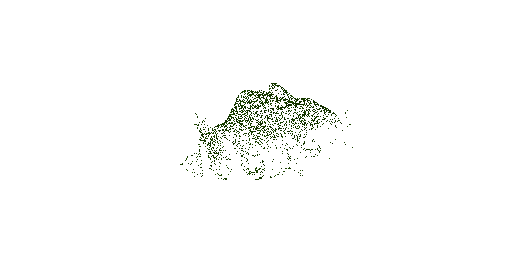

In [105]:
imshow(pth)
plt.axis("off")

In [84]:
global_linear_model = local_models.TLS_models.LinearODR_mD(2)
global_linear_model.fit(data)

In [87]:
global_linear_model.coef_
global_params_vecs = global_linear_model.coef_.reshape(2,-1)
global_params_mean = global_linear_model.intercept_
global_normal = np.cross(*global_params_vecs)

In [94]:
basis_changer = np.concatenate((global_params_vecs, global_normal.reshape(1,-1)),axis=0).T
basis_changer = np.linalg.inv(basis_changer)

In [95]:
bases_changed = np.einsum('ij,kj->ki', basis_changer, data-global_params_mean)

In [98]:
x,y,z = bases_changed.T

(-187.9690848273605,
 160.5978956286218,
 -131.18478754473625,
 174.82998666860883)

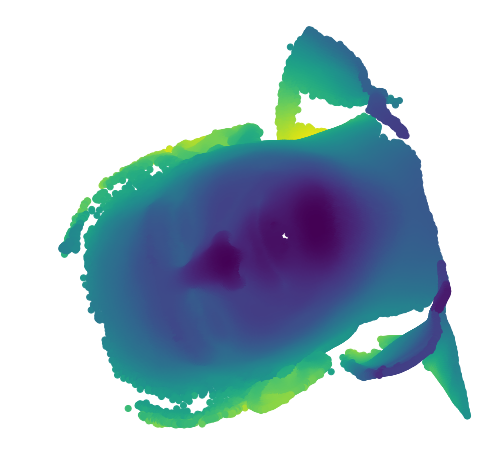

In [106]:
plt.scatter(x,y,c=z)
plt.axis("off")